# MareFEst : Mare Fertility Estimation

The following notebook illustrates the workflow of the MareFEst project within the context of the final degree project of Facultad de Ingenieria (UdelaR).

The workflow pipeline consists of:

   1. Generating model inferences across the entire WSI (nuclei, glands, or fibrosis).
   2. Aligning all the masks to be processed and dividing them into patches.
   3. Processing the resulting masks before obtaining information about them.
   4. Extracting information from images.

In [1]:
import os
import json
import sys
import random
seed_value = 46
random.seed(seed_value)

sys.path.append('src/')

from colon_epithelium_segmentation_with_postprocessing import epithelium_segmentation_wsi
from nuclei_segmentation import nuclei_segmentation_wsi
from utils.extract_all_patches import extract_all_patches, init_folder_dict, get_model_type_from_path
from preprocessing.mask_preprocess import mask_preprocessing
from utils.plot_utils import show_masks
from posprocessing.glands_posprocessing import GlandsPosprocessing


     - Powered by -     
   _______   __________   
  / __/ _ | / __/_  __/   https://fast.eriksmistad.no
 / _// __ |_\ \  / /               v4.7.0
/_/ /_/ |_/___/ /_/       



In [2]:
# Initialize
wsi_path = 'Lady.svs'

## 1. Generate inferences
The following functions take the path of a test Whole Slide Image (WSI), perform an inference, display it at the time of inference, and save it to a .tiff file. For didactic purposes, we will load previously generated .tiff files for the gland and nucleus models. The .tiff files can also be generated by running the scripts:

* `colon_epithelium_segmentation_with_postprocessing.py` or `gland-segmentation-with-postprocessing.py`
    
* `nuclei_segmentation.py`

Depending on the purpose, two different models can be run for the gland category. If you want to assess density, the **colon epithelium model** is better option, while if you want to classify or measure the shape of the glands, the model trained with GlaS (**glands model**) is recommended

In [3]:
# Run this code to make inference 
#model_epithelium = '/home/agustina/fastpathology/datahub/colon-epithelium-segmentation-he-model/HE_IBDColEpi_512_2class_140222.onnx'
#model_glands = 'models/gland-segmentation.onnx'
#model_nuceli = '/home/agustina/fastpathology/datahub/nuclei-segmentation-model/high_res_nuclei_unet.onnx'
# epithelium_segmentation_wsi(wsi_path, model_epithelium)
# nuclei_segmentation_wsi(wsi_path, model_nuclei)

## 2. Extract aligned patches
The next step is to align the Whole Slide Images (WSI) and the inferences in .tiff format to the same scale and crop them into patches. The magnification level (`level`), crop size, and other parameters are configured from a `config.json` file.

After runing `extract_all_patches()` a `report.json` file is saved in the folder with information about the patch extraction configuration along with information about the WSI.

*Note: Ignore the warnings*

In [3]:
# Create a dictionary to hold the imported parameters
config = {}
config['wsi_name'] = os.path.basename(wsi_path).split('.')[0]

# Select a glands model
glands_model = 'colon_epithelium_tiffs' # or 'gland_tiffs'

# Path to .tiff inferences
nuclei_tiff_path = f"nuclei_tiffs/{config['wsi_name']}.tiff"
fibrosis_tiffs_path = f"fibrosis_tiffs/{config['wsi_name']}.tiff"
epithelium_tiff_path = f"{glands_model}/{config['wsi_name']}.tiff"

# If the used model is the epithelium or gland model
config['glands_model_type'] = get_model_type_from_path(epithelium_tiff_path)
config['output_dir'] = init_folder_dict(None, config)

# Remove patches with background
config['bgremoved'] = True

# If True saves a patches with mask . 
# WARNING: Activating this functionality can take a long time
config['patch_visualization'] = False

# Load the configuration from the JSON file
with open('src/config.json', 'r') as config_file:
    params = json.load(config_file)
    
for key in params.keys():
    config[key] = params[key]

#extract_all_patches(wsi_path,config, nuclei_tiff_path, epithelium_tiff_path,fibrosis_tiffs_path )

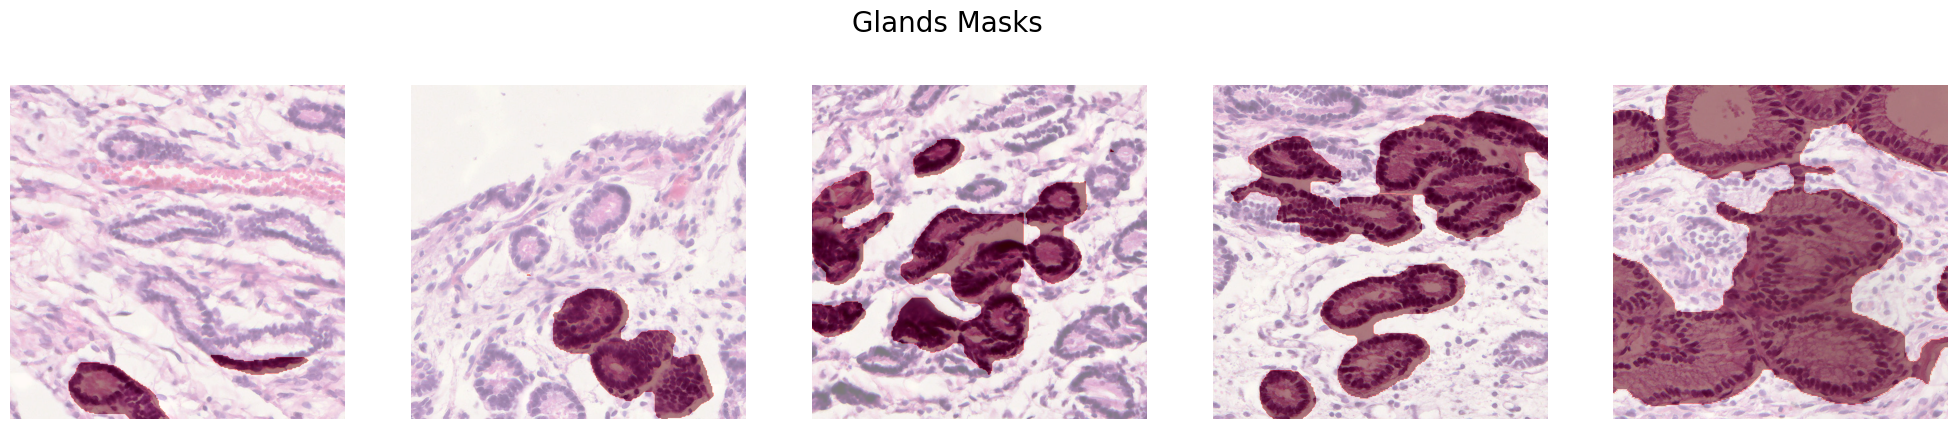

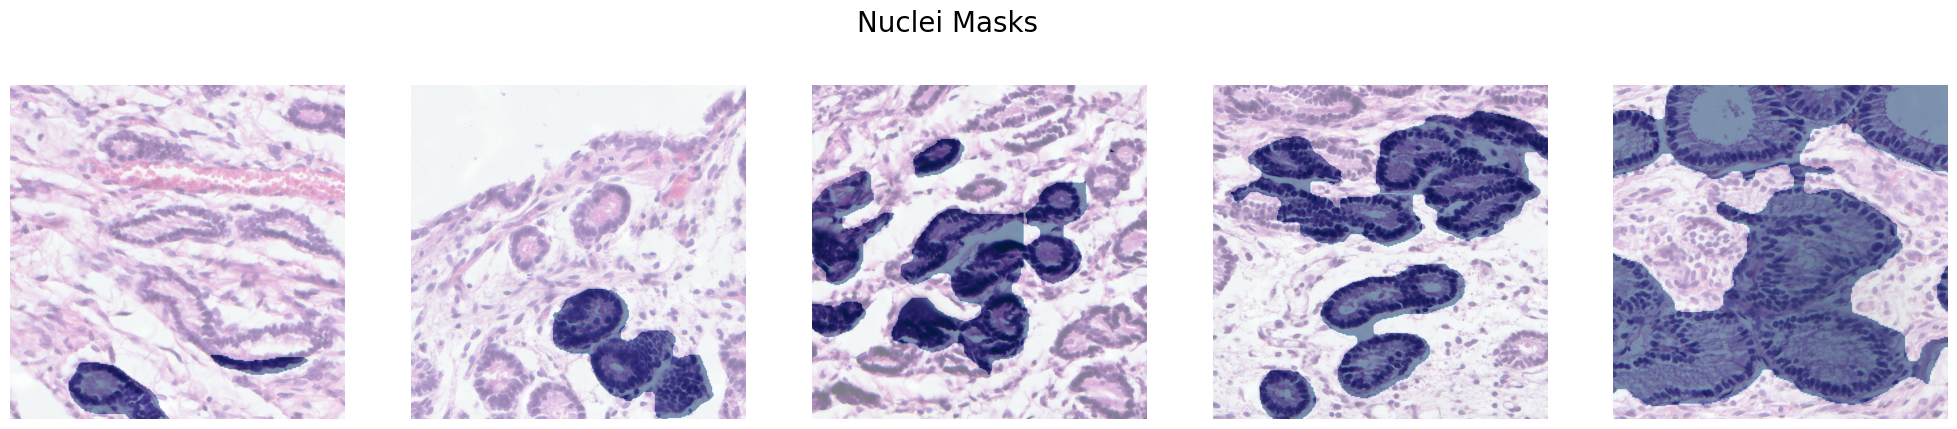

In [4]:
# Show some inferences
samples = 5
list_filenames = os.listdir(os.path.join(config['output_dir'], 'patches'))
random_items = random.sample(list_filenames, samples)

show_masks(random_items, config['output_dir'], cmap = 'Reds', channel = config['channel_epithelium'], title = 'Glands Masks')
show_masks(random_items, config['output_dir'], cmap = 'Blues', channel = config['channel_nuclei'], title = 'Nuclei Masks')

## 3. Preprocessing Mask
To clean the gland and epithelium masks, certain filters are applied to these masks. In the case of the gland mask, inferences corresponding to the contours of the WSI are removed, and the masks with holes are filled in. 

On the other hand, for nuclei masks, instances that overlap with glands are removed, and instances with large areas are also eliminated, assuming that they correspond to gland nucleis.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1670/1670 [07:26<00:00,  3.74it/s]


Preprocessing finished


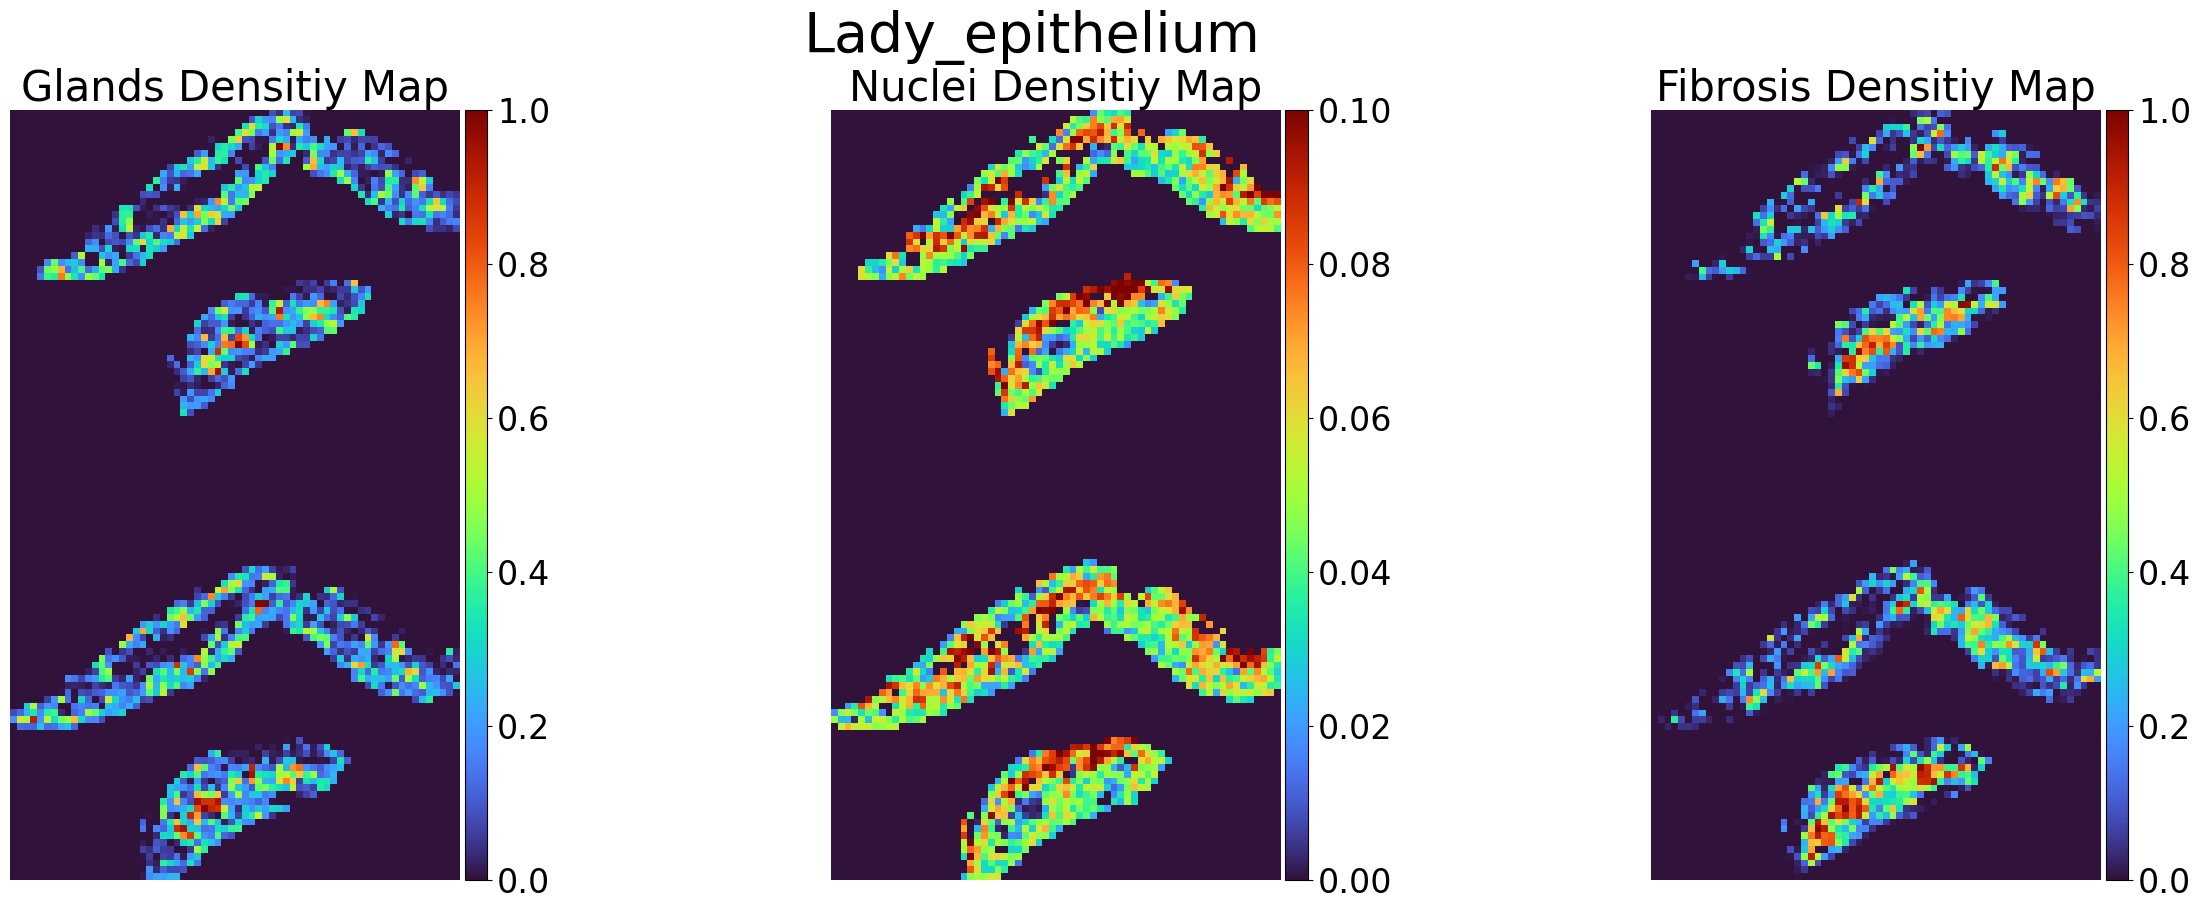

In [5]:
mask_preprocessing(src_folder = config['output_dir'],new_folder = 'new_masks')

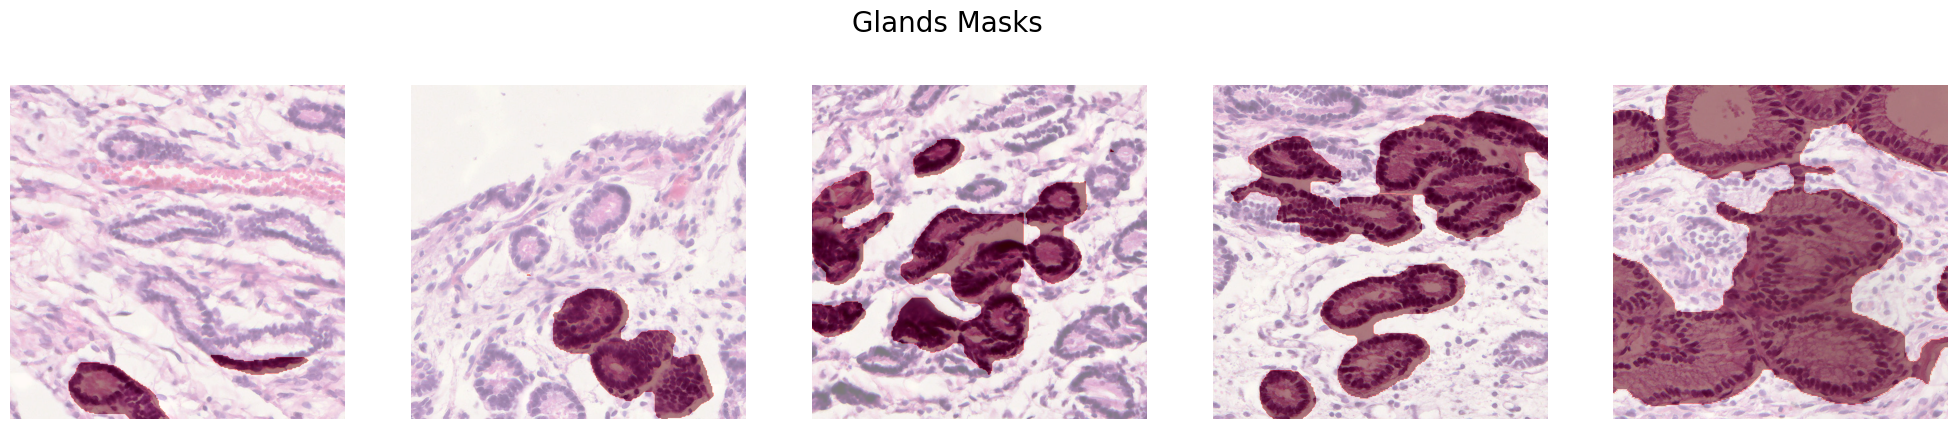

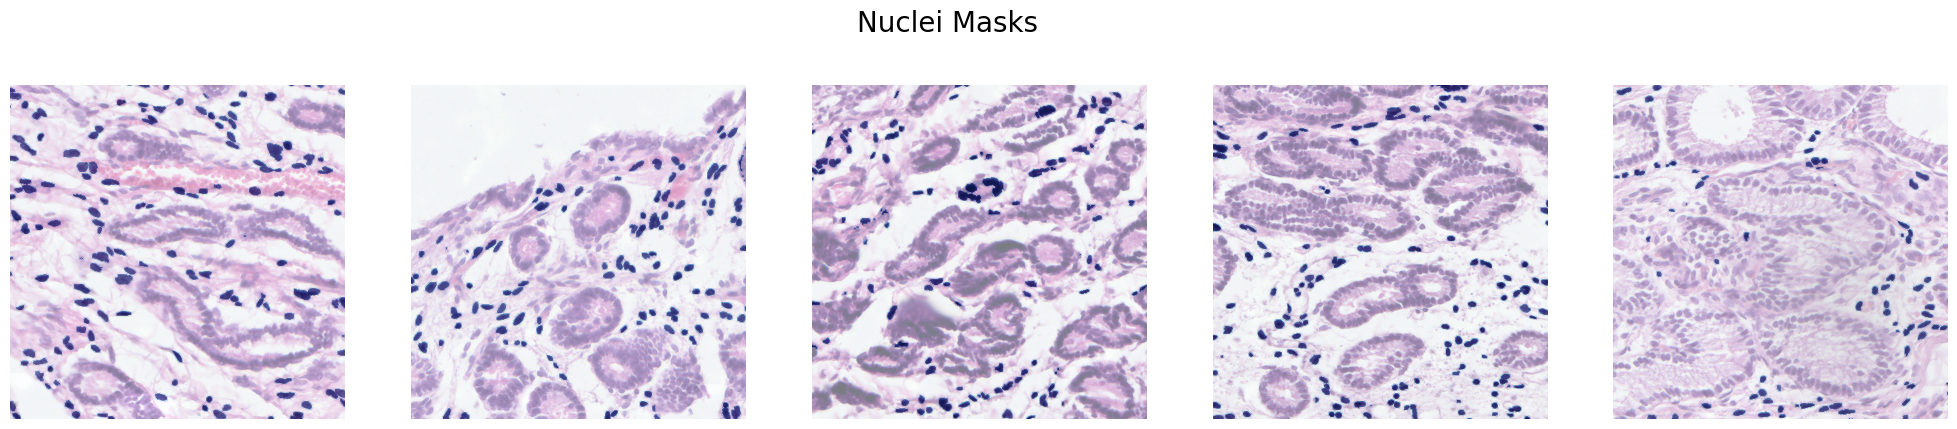

In [6]:
# See posprocessing Masks
show_masks(random_items, config['output_dir'], cmap = 'Reds', channel = config['channel_epithelium'], title = 'Glands Masks')
show_masks(random_items, config['output_dir'], cmap = 'Blues', channel = config['channel_nuclei'], title = 'Nuclei Masks')

## 4. Extracting information




### 4.1 Glands information
For each image, gland instances are separated, and the relative area of each gland in the entire image is measured. The `extract_features` function generates a DataFrame that contains information about each gland identified uniquely across the entire WSI and within the image that belongs

In [13]:
glands_posprocessing = GlandsPosprocessing(path_to_folder = config['output_dir'])
glands_posprocessing.extract_features()
glands_posprocessing.glands_data

patch_loc  patch_gland_ind  relative_area
gland_id                                             
0         76800_23552                2       0.138425
1         76800_23552               14       0.051501
2         21504_18432                1       0.020490
3         21504_18432                3       0.071018
4         21504_18432                8       0.015483
...               ...              ...            ...
4301      68608_34816                2       0.029677
4302      36864_38912                1       0.142319
4303      36864_38912                2       0.029774
4304      36864_38912                3       0.026233
4305      36864_38912                4       0.010831

[4306 rows x 3 columns]

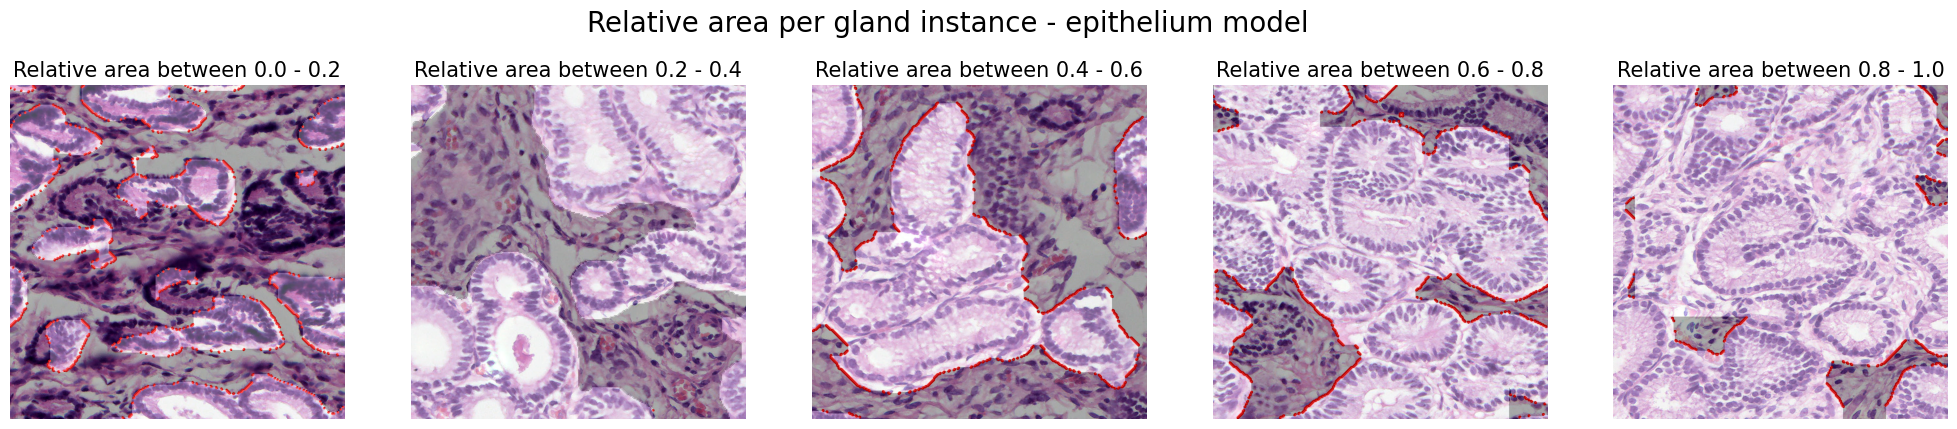

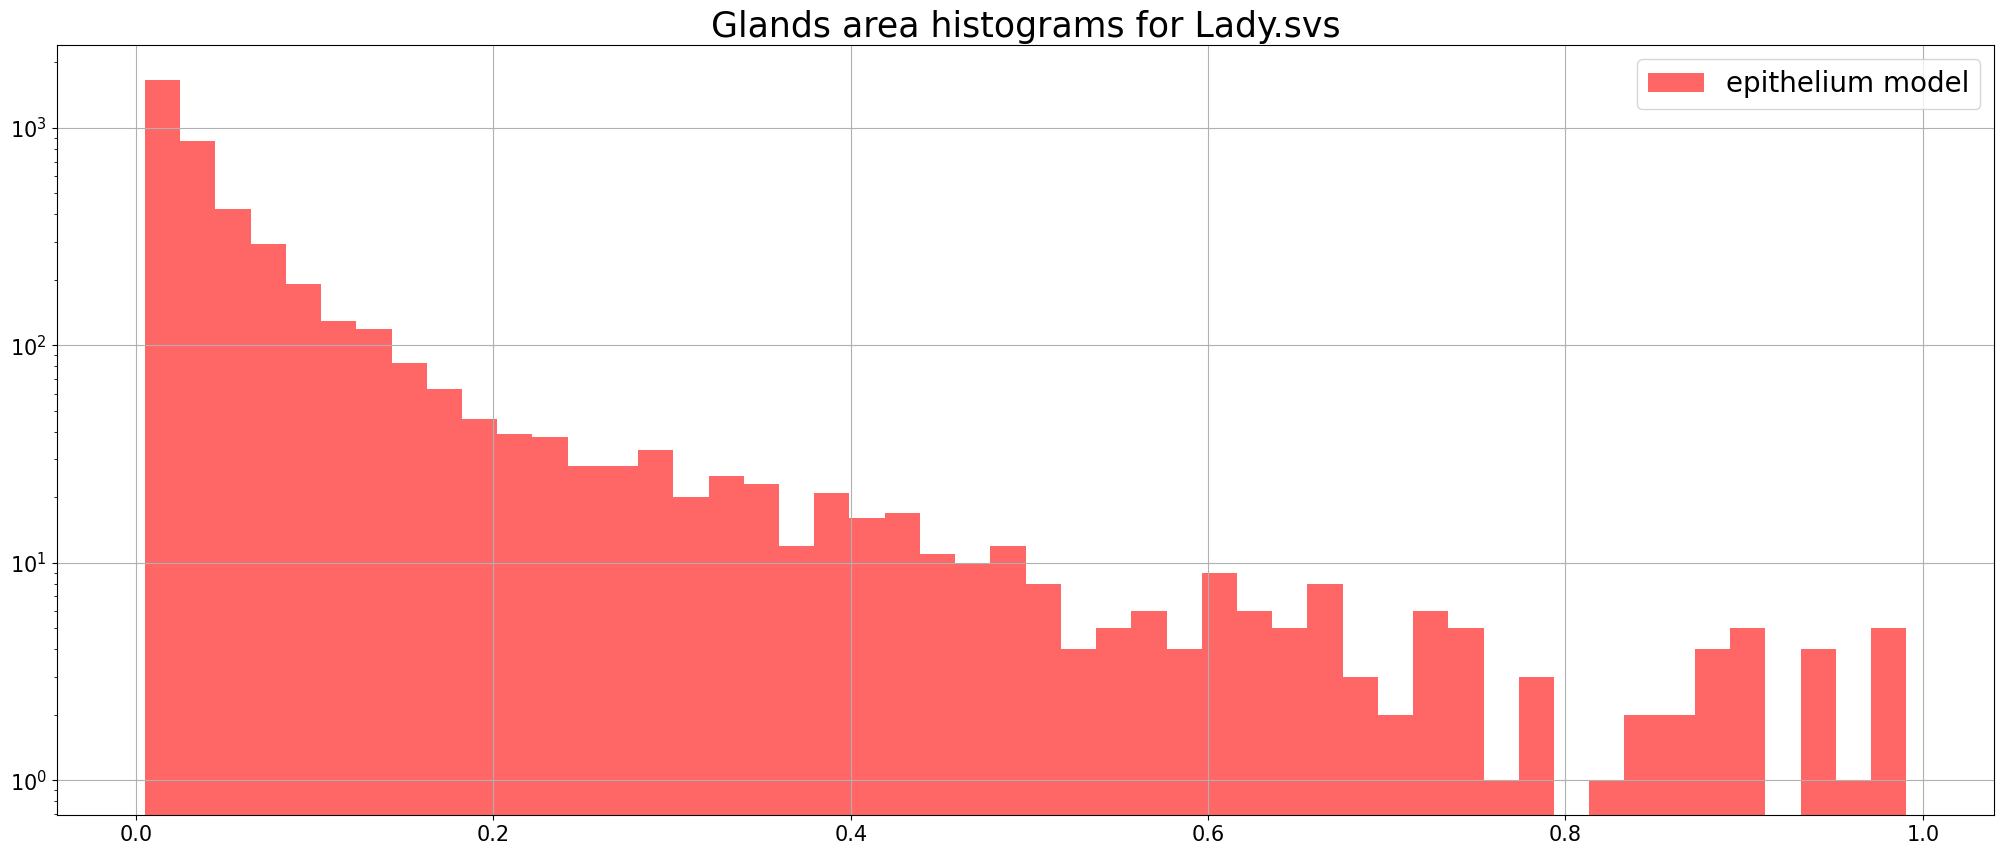

In [11]:
glands_posprocessing.plot_results()

#### Compare with others WSIs
We can run these steps for other WSIs and compare results. Next, we will retrieve data from another already processed WSI. 

*NOTE: For the comparison to be realistic, we should choose the same gland segmentation model.*

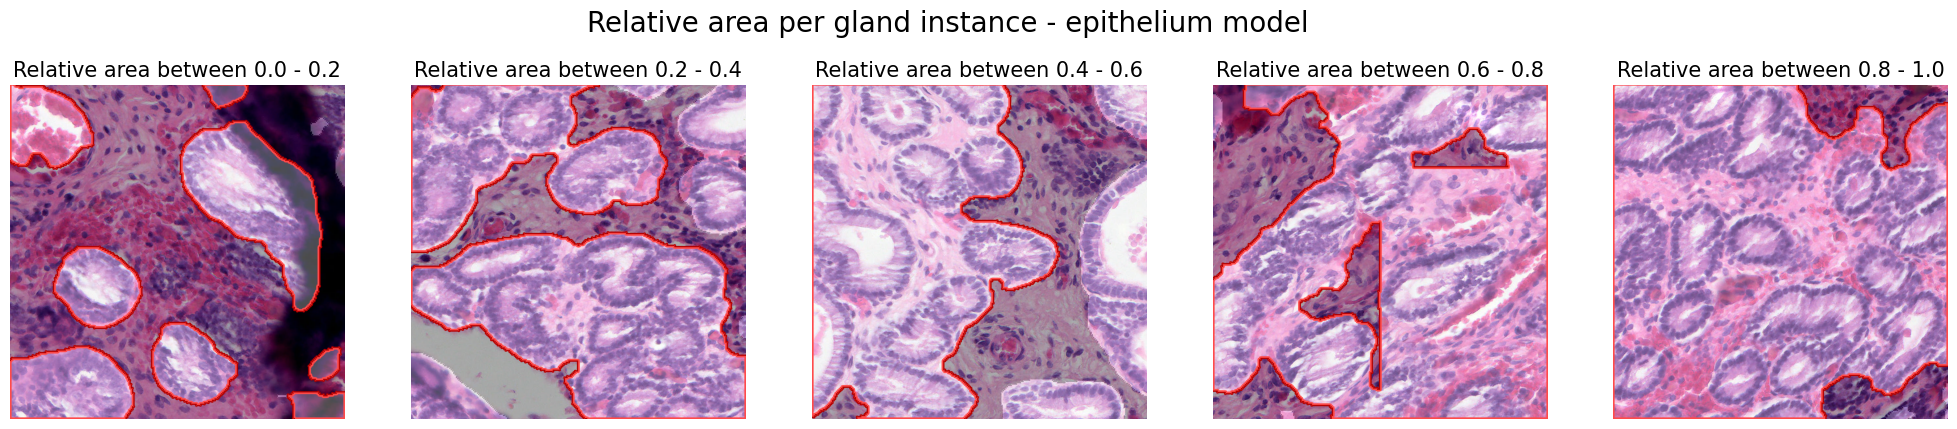

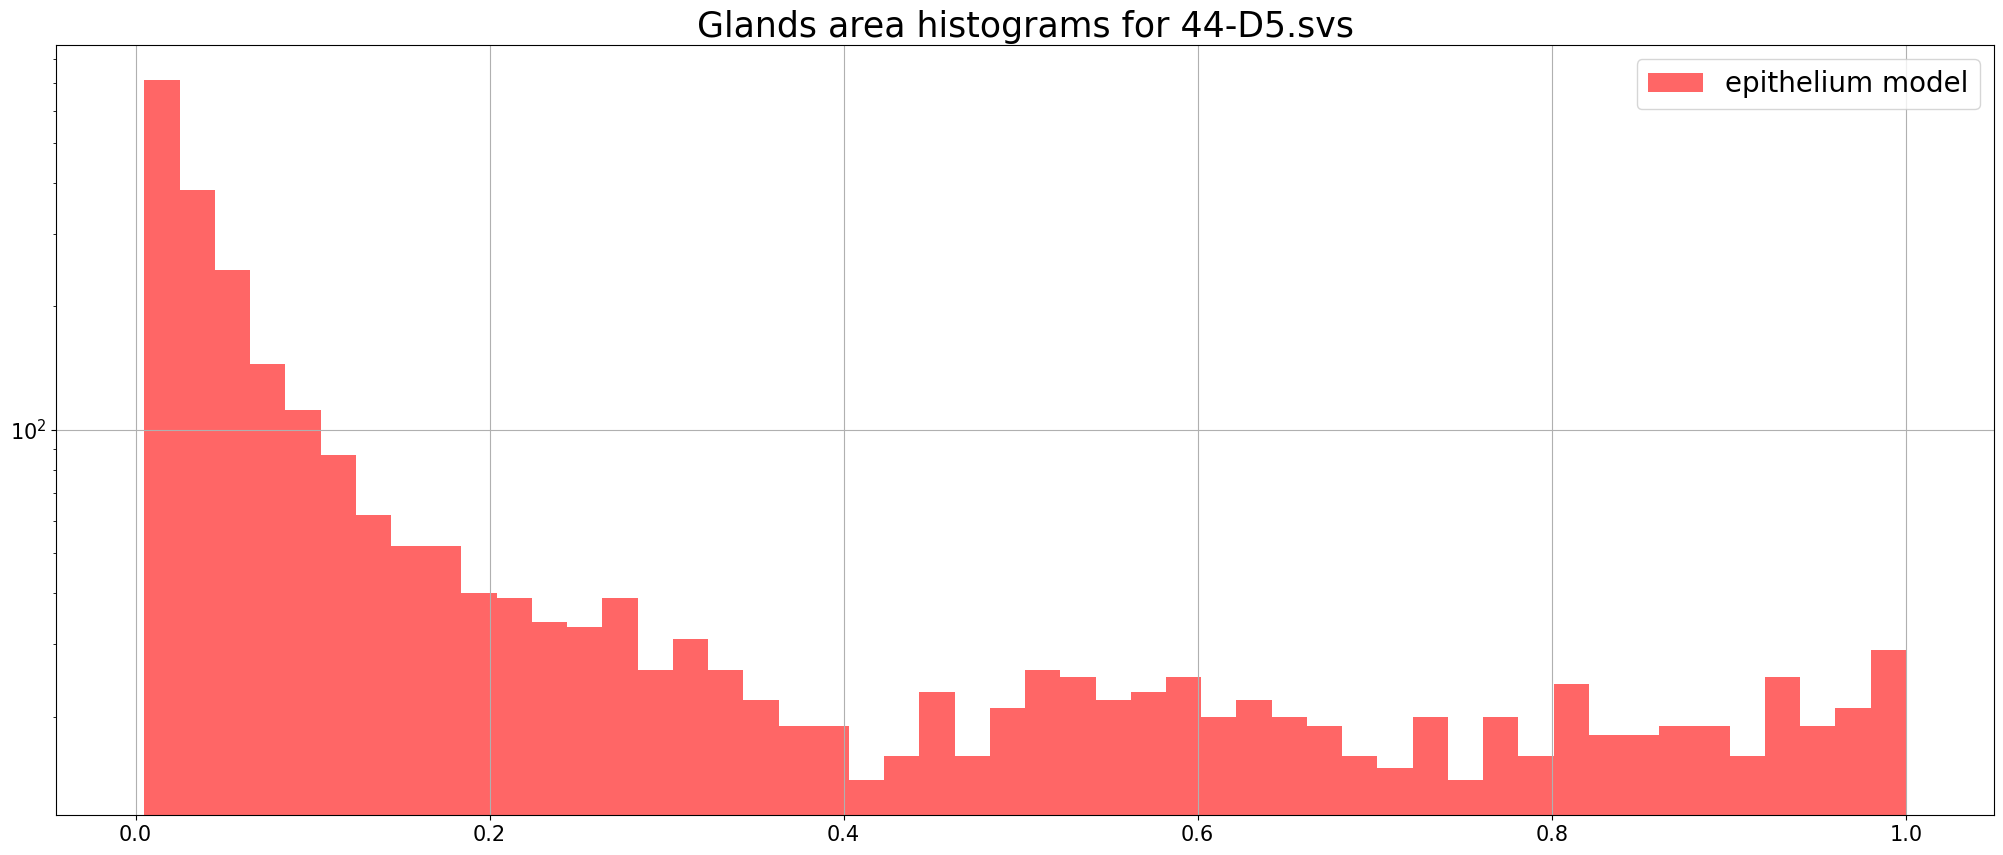

In [8]:
other_wsi_name = '44-D5' +'_'+config['glands_model_type']
other_glands_posprocessing = GlandsPosprocessing(path_to_folder = other_wsi_name)
other_glands_posprocessing.extract_features()
other_glands_posprocessing.plot_results()

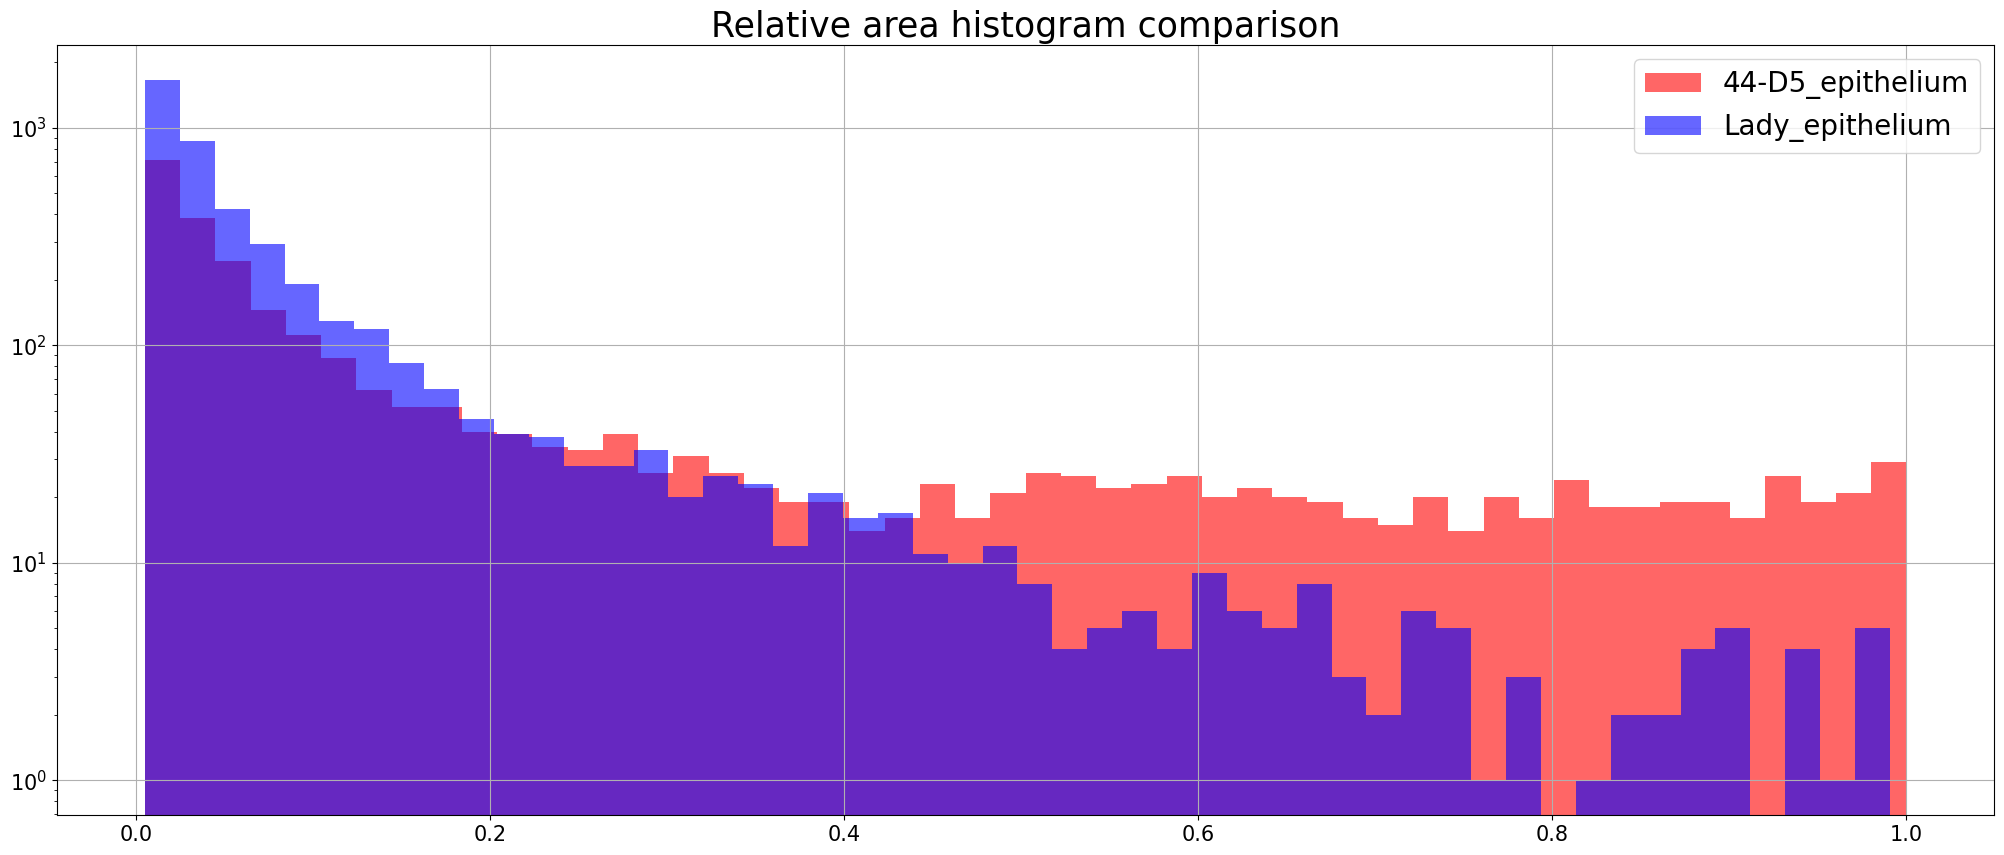

In [9]:
# See comparation
glands_posprocessing.compare_with(other_glands_posprocessing)

### 4.2 Nuclei Information